# LSTM MODEL :  미래 유동인구 예측
---

In [147]:
# 모듈 로딩
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as p
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')
import random
random.seed(42)

import matplotlib as mpl
mpl.rc('font',family='Malgun Gothic')

## [1] 모델 생성
---


데이터 과거단위 생성 함수

In [31]:
# [ 학습 단위 생성 함수 ]
# data = 사용할 데이터
# n = 학습할 과거 데이터 수
# --> 예측값 개수 : 전체 데이터 갯수 - n (앞쪽데이터 n개가 제외됨)

def generateX(data, n): # data, n=5(예시)
    x_train = []
    y_train = []
    final_test = []
    for i in range(len(data)): # i = 0~9 
        x = data[i:(i + n)] # x : 0~4,1~5,2~6,3~7,4~8,5~9...9~14
        if (i + n) < len(data): # target data가 있는 범위까지만
            x_train.append(x) # x_train = 0~4,1~5,2~6,3~7,4~8까지
            y_train.append(data[i + n]) # y_train = 5,6,7,8,9
        elif (i + n) == len(data): # ** 데이터에 없는 실제 미래 값 예측하기 위한 학습 데이터 ** 
            final_test.append(x)
        else:
            break
    return np.array(x_train), np.array(y_train), np.array(final_test)
    # x_train 개수: date개수 - n(뒤)
    # y_train 개수: date개수 - n(앞)

예측 및 그래프 함수

In [172]:
def pred_future(DATA,WINDOW_SIZE,TEST_SIZE):
    
    print(f'과거 학습 단위  : {WINDOW_SIZE}시간')
    print(f'테스트 단위     : 마지막 1일 ({TEST_SIZE}시간)')
    print(f'최종 예측       : 데이터 이후 1시간')
    print('--------------------------------')
    # [ 과거데이터 학습 단위 설정]
    x, y, z = generateX(DATA, WINDOW_SIZE) 

    print('[ before reshape ]')
    print('x.shape:',x.shape)
    print('y.shape:',y.shape)
    print('--------------------------------')
    
    # 차원 하나씩 추가 -----------------------------------------------------
    x = x.reshape(-1,WINDOW_SIZE,1)
    y = y.reshape(-1,1)
    z = z.reshape(-1,WINDOW_SIZE,1)

    print('[ after reshape ]')
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)
    print('--------------------------------')

    # 학습용 데이터와 시험용 데이터 --------------------------------------------
    x_train = x[:-TEST_SIZE, :, :]
    y_train = y[:-TEST_SIZE, :]
    x_test = x[-TEST_SIZE:, :, :]
    y_test = y[-TEST_SIZE:, :]

    print('x_train.shape:', x_train.shape,'y_train.shape:', y_train.shape)
    print('x_test.shape :', x_test.shape, 'y_test.shape :', y_test.shape)
    print('--------------------------------')

    # 모델 구성 ---------------------------------------------------------------
    model = Sequential()
    model.add(LSTM(16, 
                input_shape=(x_train.shape[1], x_train.shape[2]), 
                activation='relu', 
                return_sequences=False)
            )

    model.add(Dense(1))
    
    # 모델 컴파일 --------------------------------------------------------------
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10)

    history = model.fit(x_train, y_train, 
                                    epochs=50, 
                                    batch_size=16,
                                    validation_split=0.2,
                                    verbose=0)
                                    # callbacks=[early_stop])
    
    y_hat = model.predict(x_test)

    pred_hour = model.predict(z)

    # 모델 저장 -----------------------------------------------------------------
    # model.save('model_population.h5')

    # 예측 결과 시각화 ----------------------------------------------------------
    # 축 설정(전체 데이터 기준 )
    a_axis = np.arange(0, len(y_train))
    b_axis = np.arange(len(y_train), len(y_train) + len(y_hat))
    c_axis = np.arange(len(y_train) + len(y_hat),len(y_train) + len(y_hat) + 1 )
    # 축 설정(하루기준)
    b_axis = np.arange(0,24)
    c_axis = np.arange(24,25)

    # 학습데이터, 테스트 데이터, 테스트 예측 그래프
    plt.figure(figsize=(16,9)) 
    plt.subplot(2,1,1)
    plt.title('2022년 08월 31일의 0~23시 예측 및 확인 & 다음 1시간 예측 ' )
    #plt.plot(a_axis, y_train.reshape(x_train.shape[0],))  # 학습범위
    plt.plot(b_axis, y_hat.reshape(x_test.shape[0],),'-o', color='red', label='Predicted') # 테스트 정답
    plt.plot(b_axis, y_test.reshape(x_test.shape[0],),'-o', color='green', alpha=0.5, label='Actual') # 테스트 예측
    plt.plot(c_axis, pred_hour.reshape(z.shape[0],),'-^', color='blue', label='Future') # ** 데이터 이후 예측값1 **
    plt.legend()
    
    # LOSS, VAL_LOSS 비교 그래프(과적합 확인)
    plt.subplot(2,1,2)
    plt.title('과적합 확인(LOSS, VAL_LOSS 비교)')
    plt.plot(history.history['loss'], label = 'loss ')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.legend()
    plt.show()
    return pred_hour, z

과거 학습 단위  : 7시간
테스트 단위     : 마지막 1일 (24시간)
최종 예측       : 데이터 이후 1시간
--------------------------------
[ before reshape ]
x.shape: (8753, 7)
y.shape: (8753,)
--------------------------------
[ after reshape ]
x.shape: (8753, 7, 1)
y.shape: (8753, 1)
--------------------------------
x_train.shape: (8729, 7, 1) y_train.shape: (8729, 1)
x_test.shape : (24, 7, 1) y_test.shape : (24, 1)
--------------------------------
1/1 [==============================] - 0s 17ms/step


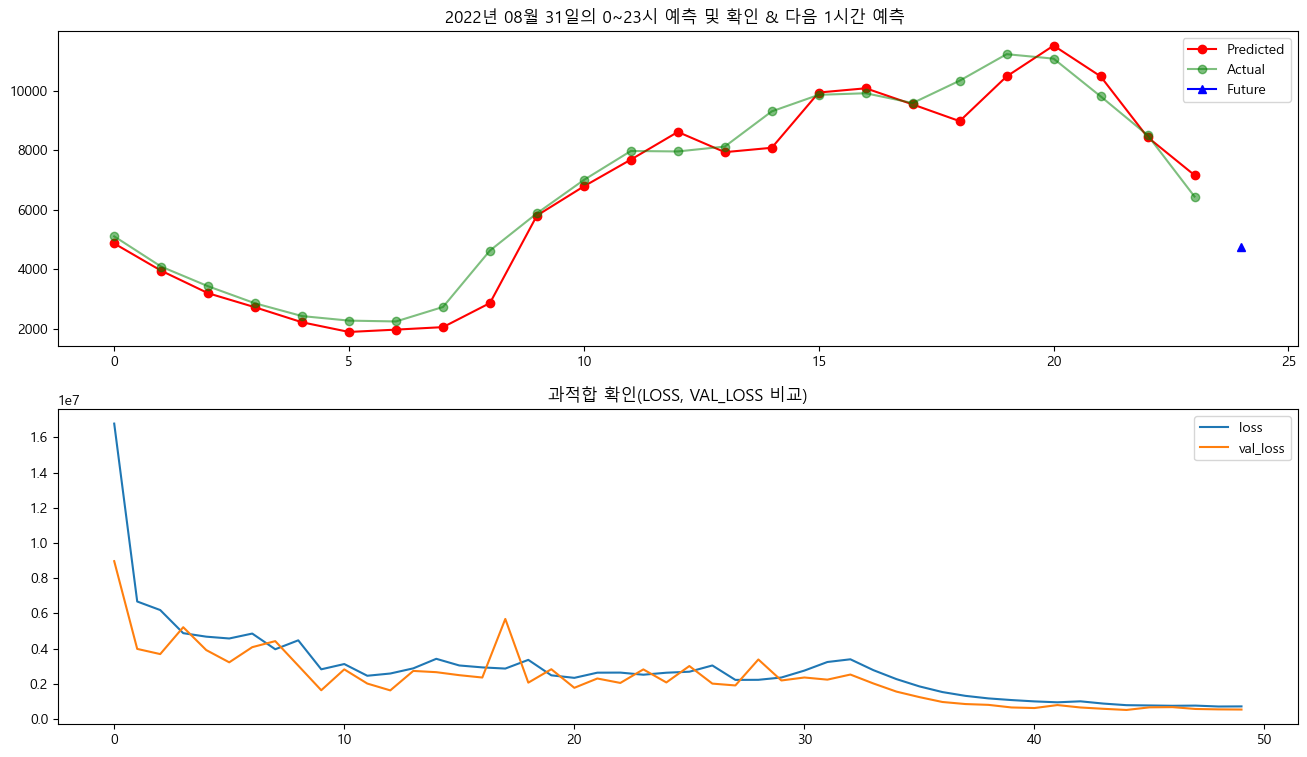

In [173]:
# 미래 예측 함수 테스트(sin 그래프)

# [ 조정 변수] : DATA, WINDOW_SIZE, TEST_SIZE

# 총 데이터
df = pd.read_csv("../data/data.csv")
df = df.iloc[:,-240:]
DATA = df["values"]

# 과거 학습 단위 = 예측하게 되는 타겟 갯수
WINDOW_SIZE = 7

# 테스트 사이즈 설정
TEST_SIZE = 24

# past_learn: 과거 학습할 데이터 단위 
pred = pred_future(DATA,WINDOW_SIZE,TEST_SIZE)

In [76]:
# 최근 7시간 : 데이터 마지막 7시간 
print('최종 예측:', pred[0])
print('학습 데이터(가장 최신 7시간):', pred[1])

최종 예측: [[4726.788]]
학습 데이터(가장 최신 7시간): [[[ 9581]
  [10331]
  [11220]
  [11070]
  [ 9806]
  [ 8504]
  [ 6443]]]


In [77]:
# 최근 7시간 : 데이터 마지막 7시간
RECENTLY_7HOURS = DATA[-7:]
RECENTLY_7HOURS

8753     9581
8754    10331
8755    11220
8756    11070
8757     9806
8758     8504
8759     6443
Name: values, dtype: int64

In [79]:
# 저장모델 성능확인
new_model = tf.keras.models.load_model('model_population.h5')

check = new_model.predict(pred[1])
print('최종 예측값: ', check)

1/1 [==============================] - 0s 100ms/step
최종 예측값:  [[4568.9116]]


# 월별/일별/요일별 유동인구 비교
--- 

In [149]:
df

,Unnamed: 0,date,values
0,0,2021-09-01 00:00:00,2070
1,1,2021-09-01 01:00:00,1773
2,2,2021-09-01 02:00:00,1618
3,3,2021-09-01 03:00:00,1549
4,4,2021-09-01 04:00:00,1501
...,...,...,...
8755,8755,2022-08-31 19:00:00,11220
8756,8756,2022-08-31 20:00:00,11070
8757,8757,2022-08-31 21:00:00,9806
8758,8758,2022-08-31 22:00:00,8504


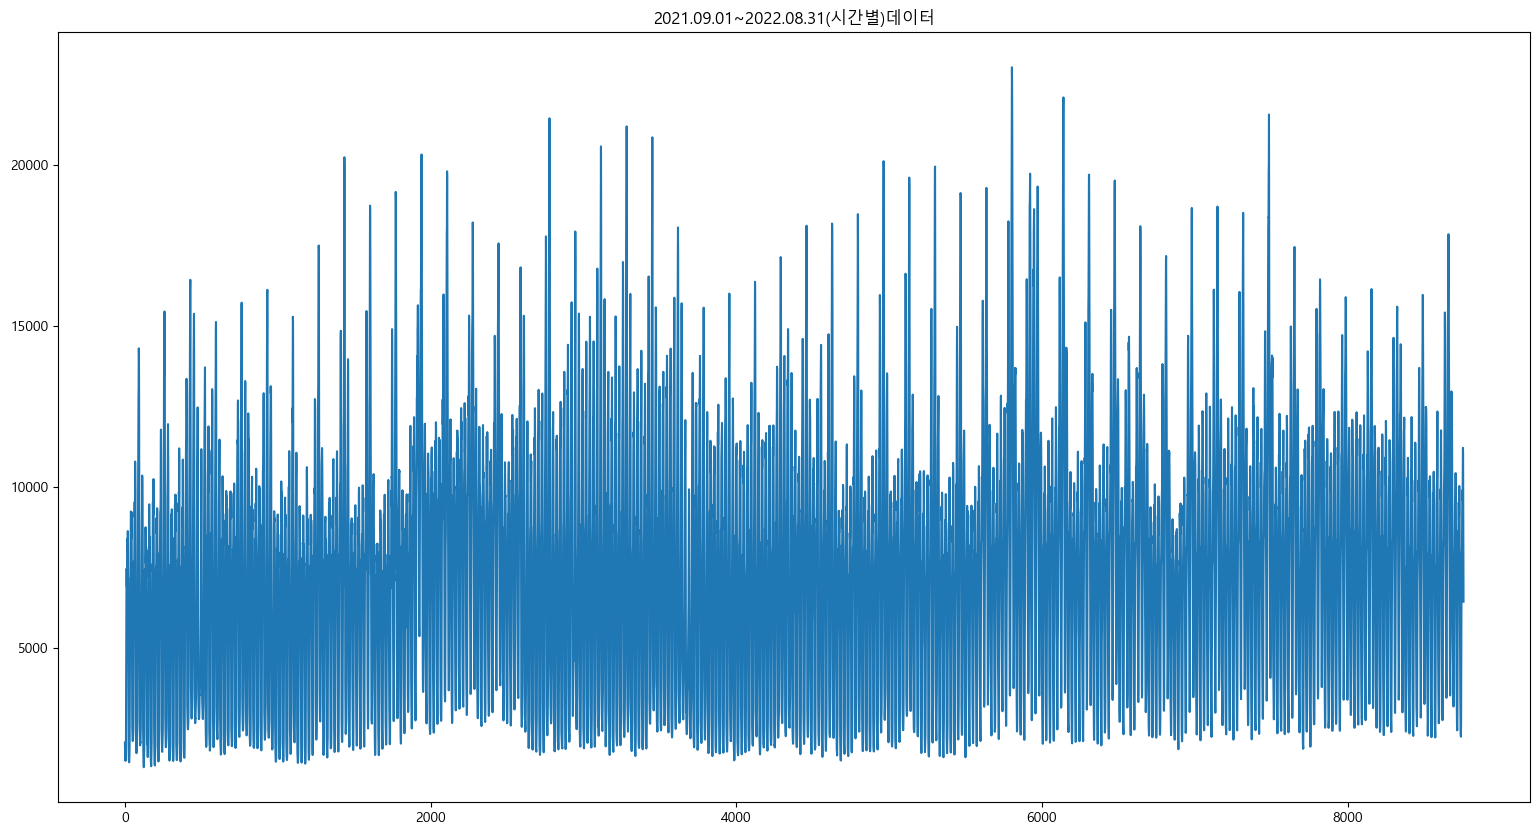

In [187]:
# 시간흐름별
plt.figure(figsize=(19,10))
plt.title('2021.09.01~2022.08.31(시간별)데이터' )
plt.plot(df['values'])
plt.show()

In [150]:
# 연도별/월별/요일별/일별 컬럼 생성
year = pd.to_datetime(df['date']).dt.year
month = pd.to_datetime(df['date']).dt.month
weekday = pd.to_datetime(df['date']).dt.day_of_week
day = pd.to_datetime(df['date']).dt.day

df.insert(0,"year",year)
df.insert(1,"month",month)
df.insert(2,"weekday",weekday)
df.insert(3,"day",day)

df

,year,month,weekday,day,Unnamed: 0,date,values
0,2021,9,2,1,0,2021-09-01 00:00:00,2070
1,2021,9,2,1,1,2021-09-01 01:00:00,1773
2,2021,9,2,1,2,2021-09-01 02:00:00,1618
3,2021,9,2,1,3,2021-09-01 03:00:00,1549
4,2021,9,2,1,4,2021-09-01 04:00:00,1501
...,...,...,...,...,...,...,...
8755,2022,8,2,31,8755,2022-08-31 19:00:00,11220
8756,2022,8,2,31,8756,2022-08-31 20:00:00,11070
8757,2022,8,2,31,8757,2022-08-31 21:00:00,9806
8758,2022,8,2,31,8758,2022-08-31 22:00:00,8504


<AxesSubplot: xlabel='month', ylabel='values'>

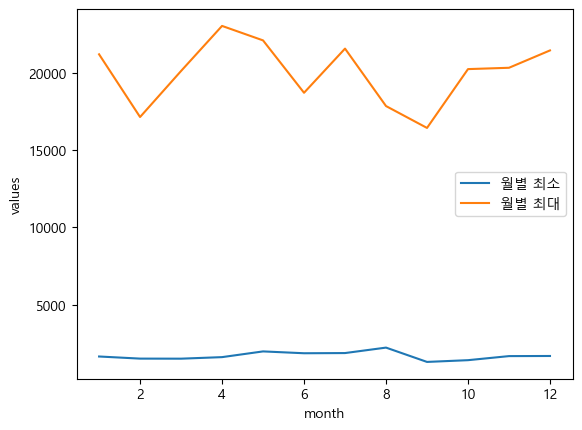

In [151]:
sns.lineplot(data=df, x='month' ,y='values', ci=None , estimator=min,label='월별 최소')
sns.lineplot(data=df, x='month' ,y='values', ci=None , estimator=max,label='월별 최대')

<AxesSubplot: xlabel='weekday', ylabel='values'>

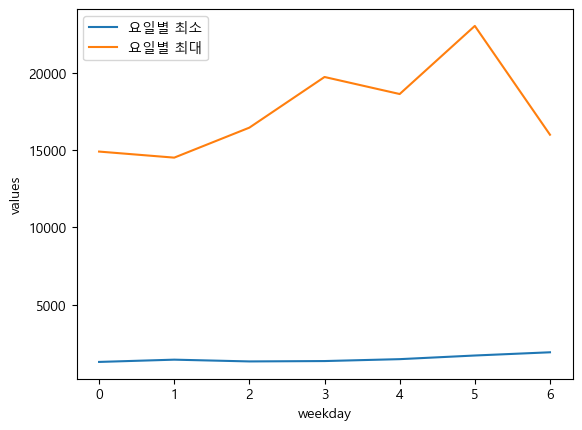

In [152]:
sns.lineplot(data=df, x='weekday' ,y='values', ci=None, estimator= min ,label='요일별 최소')
sns.lineplot(data=df, x='weekday' ,y='values', ci=None, estimator= max ,label='요일별 최대')

<AxesSubplot: xlabel='day', ylabel='values'>

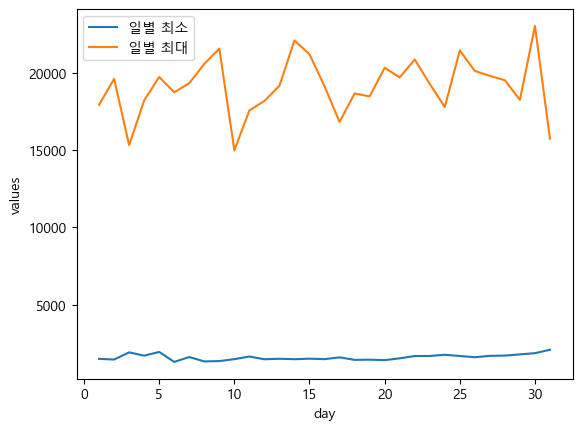

In [153]:
sns.lineplot(data=df, x='day' ,y='values', ci=None , estimator=min,label='일별 최소')
sns.lineplot(data=df, x='day' ,y='values', ci=None , estimator=max,label='일별 최대')